# Pose Estimation

**Authors:**
  
  Erlantz Calvo

  Daniel Cañadillas

**Github:**

[Github repository](https://github.com/kaecius/Head-detection-and-Pose-estimation)

## Warning: 
This notebook is not suposed to be runned cause of it's computational cost.

## Imports

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


%cd "/gdrive/MyDrive/Colab Notebooks/CNN_Pose_detection"

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/CNN_Pose_detection


In [ ]:
!pip install tqdm &> /dev/null
!pip install tensorlayer &> /dev/null
!pip install opencv-python &> /dev/null
!pip install imagesize &> /dev/null

import math

import numpy as np

from tqdm.notebook import trange, tqdm

import pandas as pd

#import tensorlayer  # Only for data downloading
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import cv2

import matplotlib.pyplot as plt

from os.path import exists,join

import imagesize

import gc

## Utils

In this section we define some functions that there will be used along the project.

In [ ]:
# Given an image path return that image resized to 220x220
def resize(im_path):
  im = cv2.imread(im_path)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  return cv2.resize(im,(220,220))

In [ ]:
#Given a file name return its index in the loaded arrays.
def get_y(file_name):
  c = -1
  for i in range(img_train_y.shape[0]):
    if len(img_train_y[i]) == 1:
      y = img_train_y[i][0]
      if y['filename'] == file_name:
        c = i
        break
  return c 

In [ ]:
#https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
# Print the model's given activation layer in a given depth applied to an image.
def print_activation(model,img_path, depth=1):

    # get all the output layers from 0 to the given depth
    layer_outputs = [layer.output for layer in model.layers[:depth]] 
    activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) 
    
    # Load the image from the given path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Reshape and convert the loaded image into a vector
    activations = activation_model.predict(cv2.resize(img,(220,220)).reshape([1,220,220,3]))
    
    
    fig = plt.figure(figsize=(15,15))
    
    last_layer = activations[0,:,:,:] if len(activations[-1].shape) == 3 else activations[-1][0,:,:,:]
    plot_sizes = math.ceil(math.sqrt(last_layer.shape[2]))
    
    # Print all the filters
    for i in range(last_layer.shape[2]):
        ax = fig.add_subplot(plot_sizes,plot_sizes,i+1)
        ax.axis('off')
        ax.imshow(last_layer[:,:,i],cmap='viridis')
        
    fig.show()
    
    # Save figure with the name "model_activation" + the given depth
    fig.savefig(f"model_activation_{depth}.jpg",format='jpg', dpi=300, bbox_inches='tight')
    

## PCKh@50 metric
 The Probability of Correct Keypoint is a metric that measures if a predicted joint is correctly placed. 

In order to measure the accuracy of points this metric gets the distance from the predicted joint to its ground truth one and then that value is normalized by the distance from the top of the head to the top of the neck. If the resulting value is less or equal than 0.5 then that joint is well predicted.

In [ ]:
def pck_h_50(y_true, y_pred):
    # Calculating the distance from the top head to the top neck.
    head_bone = tf.math.sqrt(tf.square(y_true[:,16]-y_true[:,18]) + tf.square(y_true[:,17]-y_true[:,19])) # euclidean distance for the head bone link 

    # Distance from the predicted point to the ground truth one.
    sub_pow = tf.square(tf.math.subtract(y_true,y_pred))

    sub_pow = tf.reshape(sub_pow, shape=[-1,16,2])
    sub_pow = tf.reduce_sum(sub_pow,axis=2)
    sub_pow = tf.math.sqrt(sub_pow)

    # Normalize the distance using the head-neck distance
    sub_pow = tf.transpose(sub_pow)/head_bone 

    # check if the value is less or equal than 0.5
    sub_pow = tf.dtypes.cast(tf.less_equal(sub_pow,0.5),tf.float64)

    # Convert to 1 if True and 0 if False
    sub_pow = tf.reduce_mean(sub_pow)
    
    return sub_pow

## Data

Generating train set with only images that has a single person

In [ ]:
train_x = np.array([])
train_y = np.array([])
for i in trange(img_train_x_paths.shape[0]):
  if exists(img_train_x_paths[i]) :
    index_y = get_y(img_train_x_paths[i].split('/')[-1])
    if index_y != -1:
      train_x = np.append(train_x,img_train_x_paths[i])
      train_y = np.append(train_y,img_train_y[index_y])

Head rectangle resizing from original Width x Height to 220x220 (Input size of DNN)

In [ ]:
target = np.array([])
for i in trange(img_train_y_reduced.shape[0]):
  coords = np.array(img_train_y_reduced[i]['head_rect'])
  col,row = imagesize.get(img_train_x_paths_reduced[i])

  # Getting the new coordinates in 220 x 220 using a rule of three.
  coords[0] = int(coords[0] / col * 220)
  coords[2] = int(coords[2] / col * 220)
  coords[1] = int(coords[1] / row * 220)
  coords[3] = int(coords[3] / row * 220)
  target = np.append(target,coords)
target = target.reshape([-1,4])

In [ ]:
# Save the results in a .npy file so we don't have to do this process anymore
np.save('img_train_y_head_rect_220_220.npy',target)

Converting the joint's actual points to its 220x220 representation.

In [ ]:
target_joints = np.zeros((img_train_y_reduced.shape[0],16,2))

#(0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck,
# 9 - head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
for i in trange(img_train_y_reduced.shape[0]):
  w,h = imagesize.get(img_train_x_paths_reduced[i])

  joints = img_train_y_reduced[i]['joint_pos']
  for key,value in joints.items():
    coords = [value[0], value[1]]

    # Rule of three
    coords[0] = coords[0] / w * 220
    coords[1] = coords[1] / h * 220
    target_joints[i,int(key),:] = coords
    
np.save('img_train_y_joints_220_220.npy',target_joints)


In [ ]:
#Relative path to project's folder
img_train_x_paths_reduced_relative = np.array([])
for p in tqdm(img_train_x_paths_reduced):
  img_train_x_paths_reduced_relative = np.append(img_train_x_paths_reduced_relative,'/'.join(p.split('/')[-3:]))

In [ ]:
img_train_x_paths_reduced_relative.shape

(11503,)

In [ ]:
np.save('img_train_x_paths_reduced_relative.npy',img_train_x_paths_reduced_relative)

In [ ]:
#Relative path to project's folder
img_test_x_paths_relative = np.array([])
for p in tqdm(img_test_x_paths):
  img_test_x_paths_relative = np.append(img_test_x_paths_relative,'/'.join(p.split('/')[-3:]))

np.save('img_test_x_paths_relative.npy',img_test_x_paths_relative)

## Loading Data

We load the already preprocessed data that we are going to use.

In [ ]:
img_train_y = np.load("img_train_y.npy", allow_pickle=True)
img_test_x_paths = np.load("img_test_x_paths_relative.npy")


img_train_x_paths_reduced = np.load("img_train_x_paths_reduced_relative.npy")
img_train_y_reduced = np.load("img_train_y_reduced.npy", allow_pickle=True)
img_train_y_reduced_head = np.load('img_train_y_head_rect_220_220.npy')
img_train_y_pose = np.load('img_train_y_joints_220_220.npy')


print("Train shapes: ",img_train_x_paths_reduced.shape,img_train_y_reduced.shape,img_train_y_reduced_head.shape)
print("Test shapes: ", img_test_x_paths.shape)

Train shapes:  (11503,) (11503,) (11503, 4)
Test shapes:  (6908,)


## Training data examples

In the following cell it can be seen how the images for training/evaluating the model are.

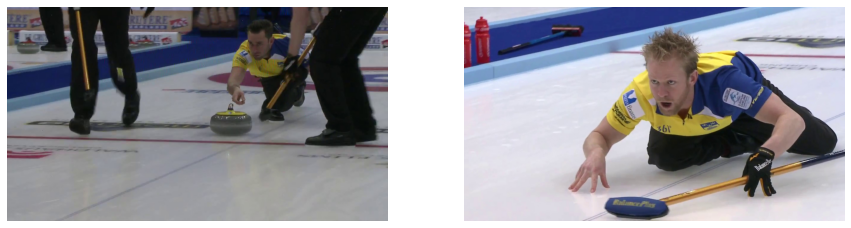

In [ ]:
plt.figure(figsize=(15,15))

# Show the first training image
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(img_train_x_paths_reduced[0]), cv2.COLOR_BGR2RGB))
plt.axis('off')

# Show the second training image
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread(img_train_x_paths_reduced[1]), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.savefig(f"dataset_example.jpg",format='jpg', dpi=300, bbox_inches='tight')
plt.show()


### Ground Truth for Head Detection

Representation of the last two images with the ground truth head coordinates over them.




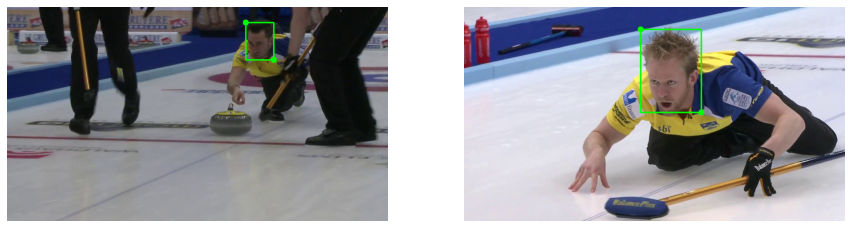

In [ ]:
# Convert images ground truth coordinates matrixes into 1D arrays
prediction_1 = img_train_y_reduced_head[0].reshape([1,-1]).astype(np.int32)
prediction_2 = img_train_y_reduced_head[1].reshape([1,-1]).astype(np.int32)

# Get the images and convert the color from BGR to RGB (CV2 library get the image in BGR)
image_1 = img_train_x_paths_reduced[0]
image_1 = cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB)

image_2 = img_train_x_paths_reduced[1]
image_2 = cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB)

# Get the original dimensions of the images
width_1, height_1 = imagesize.get(img_train_x_paths_reduced[0])
width_2, height_2 = imagesize.get(img_train_x_paths_reduced[0])

# Converting hte ground truth coordinates into same coordinates for  220x220 image using a Rule of three
prediction_1[0,0] = int(prediction_1[0,0]/220 * width_1)
prediction_1[0,2] = int(prediction_1[0,2]/220 * width_1)
prediction_1[0,1] = int(prediction_1[0,1]/220 * height_1)
prediction_1[0,3] = int(prediction_1[0,3]/220 * height_1)

prediction_2[0,0] = int(prediction_2[0,0]/220 * width_2)
prediction_2[0,2] = int(prediction_2[0,2]/220 * width_2)
prediction_2[0,1] = int(prediction_2[0,1]/220 * height_2)
prediction_2[0,3] = int(prediction_2[0,3]/220 * height_2)
    
#(X1, Y1) and (X2, Y2) of the box    
start_point_1 = (prediction_1[0,0], prediction_1[0,1])
end_point_1 = (prediction_1[0,2], prediction_1[0,3])
start_point_2 = (prediction_2[0,0], prediction_2[0,1])
end_point_2 = (prediction_2[0,2], prediction_2[0,3])

# Color of box (Green)
color = (0, 255, 0)
thickness = 3

# Adding two points to the boxes representing the coordinates given
image_1 = cv2.circle(image_1, start_point_1, radius=10, color=color, thickness=-1)
image_1 = cv2.circle(image_1, end_point_1, radius=10, color=color, thickness=-1)
image_1 = cv2.rectangle(image_1, start_point_1, end_point_1, color, thickness)

image_2 = cv2.circle(image_2, start_point_2, radius=10, color=color, thickness=-1)
image_2 = cv2.circle(image_2, end_point_2, radius=10, color=color, thickness=-1)
image_2 = cv2.rectangle(image_2, start_point_2, end_point_2, color, thickness)
        
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image_1)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(image_2)

plt.savefig('gt_head_estimation.jpg',format='jpg', dpi=300, bbox_inches='tight')
plt.show()

### Ground Truth for Pose Estimation

Representation of the last two images with the ground truth joint coordinates over them.

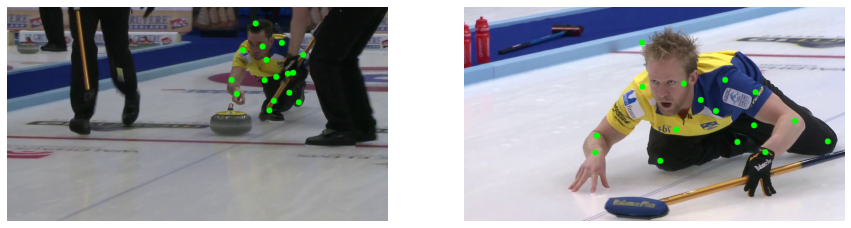

In [ ]:
prediction_1 = img_train_y_pose[0].reshape([1,-1])
prediction_2 = img_train_y_pose[1].reshape([1,-1])

image_1 = img_train_x_paths_reduced[0]
image_1 = cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB)

image_2 = img_train_x_paths_reduced[1]
image_2 = cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB)


width_1, height_1 = imagesize.get(img_train_x_paths_reduced[0])
width_2, height_2 = imagesize.get(img_train_x_paths_reduced[0])


for i in range(0,32,2):
    joint_x_1, joint_y_1 = (int(prediction_1[0,i]/220 * width_1), int(prediction_1[0,i+1] / 220 * height_1))
    joint_x_2, joint_y_2 = (int(prediction_2[0,i]/220 * width_2), int(prediction_2[0,i+1] / 220 * height_2))

    if(joint_x_1 < 1 and joint_y_1 < 1) or (joint_x_2 < 1 and joint_y_2 < 1):
        continue
                
    color = (0, 255, 0)
    thickness = -1
        
    image_1 = cv2.circle(image_1, (joint_x_1,joint_y_1), radius=10, color=color, thickness=thickness)
    image_2 = cv2.circle(image_2, (joint_x_2,joint_y_2), radius=10, color=color, thickness=thickness)
    
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(image_1)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(image_2)

plt.savefig('gt_pose_estimation.jpg',format='jpg', dpi=300, bbox_inches='tight')
plt.show()

## Head Detection

Deep pose based model used for head detection. The input is a 220x220 image and the output are 4 continuous values:

**X1, Y1:** Coordinates of the upper-left corner of the head containing box.

**X2, Y2:** Coordinates of the bottom-right corner of the head containing box.


Deep Pose

In [ ]:
class DeepPoseHeadDetection():
  '''
  Poner lo que usa la clase
  '''

  def __init__(self, model='deeppose'):

    if model == 'resnet':
        self.model = self._init_resnet()
    else:
        self.model = self._init_deeppose()
    
    self.model.compile(keras.optimizers.Adam(lr=0.0005), loss=["mean_squared_error"], metrics=["mean_squared_error"]) # Compile Model optimized by Adam and function loss as mean squared error

  def _init_deeppose(self):
    model = keras.models.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape=(220,220,3))) # Input Layer
    model.add(tf.keras.layers.Lambda(lambda image: image/255)) # Normalization Layer for Computational time reduction
    model.add(keras.layers.Conv2D(96,11,activation='relu',strides=(4,4),input_shape=(220,220,3), padding='same')) # 11x11x96 Convolutional Layer (Relu activation function)
    model.add(keras.layers.Lambda(tf.nn.local_response_normalization)) # Local Response Normalization Layer
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
    model.add(keras.layers.Conv2D(256,5,activation='relu', padding='same')) # 5x5x256 Convolutional Layer (Relu activation function)
    model.add(keras.layers.Lambda(tf.nn.local_response_normalization)) # Local Response Normalization Layer
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
    model.add(keras.layers.Conv2D(384,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
    model.add(keras.layers.Conv2D(384,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
    model.add(keras.layers.Conv2D(256,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
    model.add(keras.layers.Flatten()) # Vectorize
    model.add(keras.layers.Dense(4096,activation='relu')) # 4096 neurons - Full Connected Layer 
    model.add(keras.layers.Dropout(0.6))
    model.add(keras.layers.Dense(4096,activation='relu')) # 4096 neurons - Full Connected Layer
    model.add(keras.layers.Dropout(0.6))
    model.add(keras.layers.Dense(4,activation='relu')) # Output Layer
    
    return model
    
  def _init_resnet(self):
    model = tf.keras.applications.ResNet50V2(input_shape=(220,220,3),include_top=False)
    out = model.output
    out = keras.layers.Dense(2048,activation='relu')(out) # 4096 neurons - Full Connected Layer 
    out = keras.layers.Dense(2048,activation='relu')(out) # 4096 neurons - Full Connected Layer  
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dense(4,activation='relu')(out) #Output Layer
    
    return keras.Model(model.input,out)
    
  def summary(self):
    print(self.model.summary())
  
  def load_model(self,model_path):
    self.model = keras.models.load_model(model_path)

  def fit(self,X ,Y ,epochs = 100, batch_size = 128, save_model = False, save_model_path= None, save_weights = False, save_weights_path= None):
    train_x_dataframe = pd.DataFrame(data = X, columns=['filename'])
    target_dataframe = pd.DataFrame(data = Y, columns=['y_col']*4)
    dt = pd.concat([train_x_dataframe,target_dataframe], axis=1)

    gn = keras.preprocessing.image.ImageDataGenerator(validation_split=0.1) # Image Data Generator for reducing RAM usage

    class CustomModelSaver(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
                filename = f"model_{epoch}.h5"
                self.model.save(join(save_model_path,filename))

    class CustomWeightsSaver(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
                filename = f"weights_{epoch}.h5"
                self.model.save_weights(join(save_weights_path,filename))
                    
    callbacks = []
        
    if save_model:
        callbacks.append(CustomModelSaver())
            
    if save_weights:
        callbacks.append(CustomWeightsSaver())

    train_set = gn.flow_from_dataframe(dt,target_size=(220, 220),y_col='y_col',class_mode='raw', batch_size=batch_size, subset="training")
    validation_set = gn.flow_from_dataframe(dt,target_size=(220, 220),y_col='y_col',class_mode='raw', batch_size=batch_size, subset="validation")

    return self.model.fit(train_set, validation_data= validation_set,epochs=epochs,verbose=1, callbacks=callbacks)

  def predict(self,X, print_results= False):
    predictions  = np.array([])

    for image in tqdm(X):
      width, height = imagesize.get(image)

      # Predicting
      prediction = self.model.predict(resize(image).reshape([1,220,220,3]))

      # Converting to real image dims
      prediction[0,0] = int(prediction[0,0]/220 * width)
      prediction[0,2] = int(prediction[0,2]/220 * width)
      prediction[0,1] = int(prediction[0,1]/220 * height)
      prediction[0,3] = int(prediction[0,3]/220 * height)

      predictions = np.append(predictions, prediction)
      
      if print_results:
        start_point = (prediction[0,0], prediction[0,1])
        end_point = (prediction[0,2], prediction[0,3])
        color = (255, 0, 0)
        thickness = 2

        image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        plt.figure()
        plt.imshow(image)

    return predictions.reshape([-1,4])

  def save_model(self,path):
    self.model.save(path)
    
  def save_weights(self,path):
    self.model.save_weights(path)

  def load_weights(self,path):
    self.model.load_weights(path)

  def plot_model(self,path_w_filename):
    plot_model(self.model, to_file=path_w_filename, show_shapes=True, show_layer_names=False)
  

In [ ]:
model = DeepPoseHeadDetection()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 220, 220, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
lambda_16 (Lambda)           (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
lambda_17 (Lambda)           (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 256)      

In [ ]:
%mkdir model_local_head
hist = model.fit(img_train_x_paths_reduced,img_train_y_reduced_head, save_weights=True, save_weights_path='model_local_head')

Ya existe el subdirectorio o el archivo model_local_head.


Found 10353 validated image filenames.
Found 1150 validated image filenames.
Epoch 1/100
81/81 [==============================] - 307s 4s/step - loss: 2063.8738 - mean_squared_error: 2063.8738 - val_loss: 983.0004 - val_mean_squared_error: 983.0004
Epoch 2/100
81/81 [==============================] - 211s 3s/step - loss: 1093.2059 - mean_squared_error: 1093.2059 - val_loss: 1038.5065 - val_mean_squared_error: 1038.5065
Epoch 3/100
81/81 [==============================] - 209s 3s/step - loss: 1058.2523 - mean_squared_error: 1058.2523 - val_loss: 1021.1912 - val_mean_squared_error: 1021.1912
Epoch 4/100
81/81 [==============================] - 202s 2s/step - loss: 1063.4420 - mean_squared_error: 1063.4420 - val_loss: 976.1501 - val_mean_squared_error: 976.1501
Epoch 5/100
81/81 [==============================] - 200s 2s/step - loss: 1073.0100 - mean_squared_error: 1073.0100 - val_loss: 1047.7533 - val_mean_squared_error: 1047.7533
Epoch 6/100
81/81 [==============================] - 200s

81/81 [==============================] - 201s 2s/step - loss: 108.1443 - mean_squared_error: 108.1443 - val_loss: 425.6999 - val_mean_squared_error: 425.6999
Epoch 49/100
81/81 [==============================] - 202s 2s/step - loss: 101.4060 - mean_squared_error: 101.4060 - val_loss: 422.2231 - val_mean_squared_error: 422.2231
Epoch 50/100
81/81 [==============================] - 201s 2s/step - loss: 102.0017 - mean_squared_error: 102.0017 - val_loss: 428.0450 - val_mean_squared_error: 428.0450
Epoch 51/100
81/81 [==============================] - 202s 2s/step - loss: 99.4013 - mean_squared_error: 99.4013 - val_loss: 429.3472 - val_mean_squared_error: 429.3472
Epoch 52/100
81/81 [==============================] - 202s 2s/step - loss: 93.6290 - mean_squared_error: 93.6290 - val_loss: 423.6002 - val_mean_squared_error: 423.6002
Epoch 53/100
81/81 [==============================] - 201s 2s/step - loss: 88.6494 - mean_squared_error: 88.6494 - val_loss: 415.5436 - val_mean_squared_error: 41

81/81 [==============================] - 201s 2s/step - loss: 51.7204 - mean_squared_error: 51.7204 - val_loss: 436.9727 - val_mean_squared_error: 436.9727
Epoch 97/100
81/81 [==============================] - 201s 2s/step - loss: 50.1314 - mean_squared_error: 50.1314 - val_loss: 407.1863 - val_mean_squared_error: 407.1863
Epoch 98/100
81/81 [==============================] - 202s 2s/step - loss: 49.7924 - mean_squared_error: 49.7924 - val_loss: 396.6723 - val_mean_squared_error: 396.6723
Epoch 99/100
81/81 [==============================] - 201s 2s/step - loss: 48.7930 - mean_squared_error: 48.7930 - val_loss: 416.9060 - val_mean_squared_error: 416.9060
Epoch 100/100
81/81 [==============================] - 202s 2s/step - loss: 48.9821 - mean_squared_error: 48.9821 - val_loss: 420.4467 - val_mean_squared_error: 420.4467


Chart that represents the loss of the head detection using the deep pose based model during epochs.

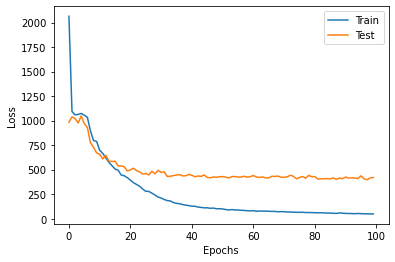

In [ ]:
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Test'], loc='upper right')
plt.savefig('cnn_training.jpg',format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.save_weights('model_local_head/weights_100.h5')
del model

In [ ]:
model_res = DeepPoseHeadDetection(model="resnet")
model_res.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
model_res.fit(img_train_x_paths_reduced,img_train_y_reduced_head, save=True, save_path='model_local_resnet', batch_size=32)

Found 10353 validated image filenames.
Found 1150 validated image filenames.
Epoch 1/100
324/324 [==============================] - 261s 806ms/step - loss: 517.5902 - mean_squared_error: 517.5902 - val_loss: 379.0780 - val_mean_squared_error: 379.0780
Epoch 2/100
324/324 [==============================] - 212s 654ms/step - loss: 233.7688 - mean_squared_error: 233.7688 - val_loss: 527.3602 - val_mean_squared_error: 527.3602
Epoch 3/100
324/324 [==============================] - 212s 654ms/step - loss: 170.8119 - mean_squared_error: 170.8119 - val_loss: 284.8381 - val_mean_squared_error: 284.8381
Epoch 4/100
324/324 [==============================] - 212s 655ms/step - loss: 133.5050 - mean_squared_error: 133.5050 - val_loss: 272.6675 - val_mean_squared_error: 272.6675
Epoch 5/100
324/324 [==============================] - 208s 642ms/step - loss: 99.2466 - mean_squared_error: 99.2466 - val_loss: 337.1264 - val_mean_squared_error: 337.1264
Epoch 6/100
324/324 [=============================

Epoch 48/100
324/324 [==============================] - 207s 640ms/step - loss: 5.0808 - mean_squared_error: 5.0808 - val_loss: 168.2845 - val_mean_squared_error: 168.2845
Epoch 49/100
324/324 [==============================] - 207s 638ms/step - loss: 5.5816 - mean_squared_error: 5.5816 - val_loss: 162.2893 - val_mean_squared_error: 162.2893
Epoch 50/100
324/324 [==============================] - 207s 640ms/step - loss: 146.3845 - mean_squared_error: 146.3845 - val_loss: 425.6854 - val_mean_squared_error: 425.6854
Epoch 51/100
324/324 [==============================] - 209s 644ms/step - loss: 80.3668 - mean_squared_error: 80.3668 - val_loss: 270.2225 - val_mean_squared_error: 270.2225
Epoch 52/100
324/324 [==============================] - 208s 642ms/step - loss: 33.4347 - mean_squared_error: 33.4347 - val_loss: 197.5412 - val_mean_squared_error: 197.5412
Epoch 53/100
324/324 [==============================] - 209s 646ms/step - loss: 18.1991 - mean_squared_error: 18.1991 - val_loss: 17

Chart that represents the loss of the head detection using the ResNet model during epochs.

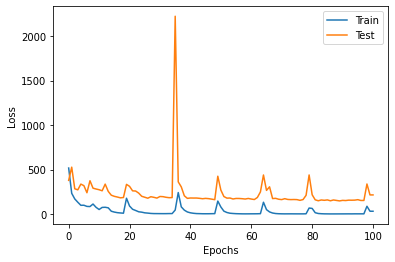

In [ ]:
train_loss = []
eval_loss = []
y = 0
with open('train_loss') as file:
  for line in file:
    train_loss.append(float(line.split(' ')[0]))
    eval_loss.append(float(line.split(' ')[1]))

plt.figure()
plt.plot(train_loss)
plt.plot(eval_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'],loc='upper right')
plt.savefig('resnet_head_training.jpg', format = 'jpg', dpi = 300, bbox_inches = 'tight')
plt.show()


In [ ]:
model_res.save_model('model_local_resnet/model_100.h5')
del model_res1

## Some testing and visualizations

In the following cells it will be shown how both of the trained models perform with some omages taken from internet.

In [ ]:
test_images = ['testing/test.jpg','testing/test_backwards.jpg','testing/test_mask.jpg','testing/test_statue.jpg','testing/test_anime.jpg','testing/test_animal.jpg']

In [ ]:
model_resnet_100 = DeepPoseHeadDetection()
model_resnet_100.load_model("model_local_resnet/model_100.h5")

### Predictions using the ResNet model

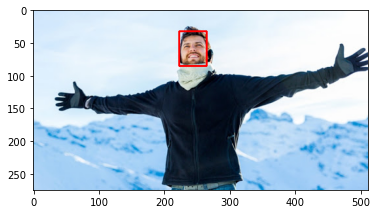

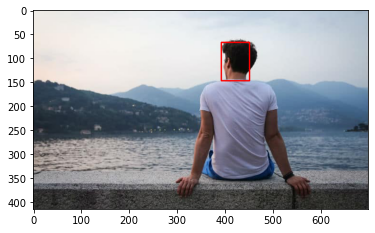

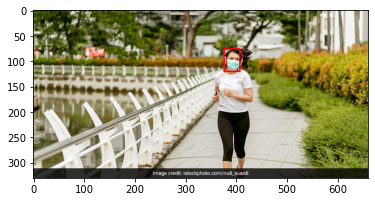

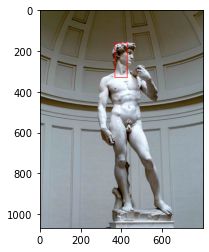

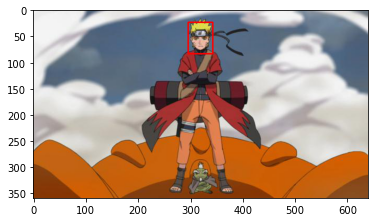

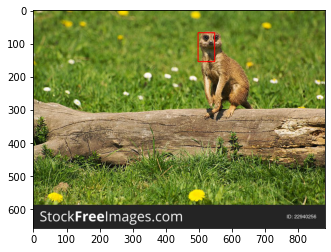

In [ ]:
predictions_resnet = model_resnet_100.predict(test_images, print_results=True)

Filters learned by the ResNet model.

E:\Users\danie\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


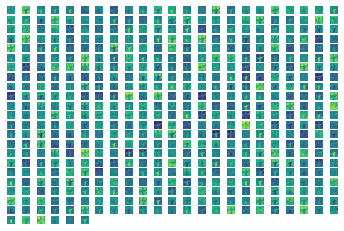

In [ ]:
print_activation(model_resnet_100.model,'testing/test.jpg')

### Predictions using the Deep pose based model

In [ ]:
model_cnn_100 = DeepPoseHeadDetection()
model_cnn_100.load_weights("model_local_head/weights_100.h5")

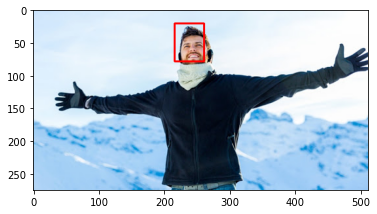

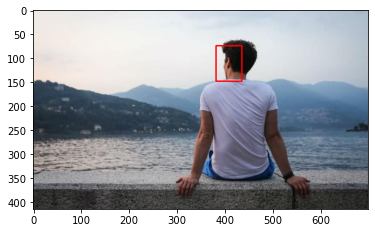

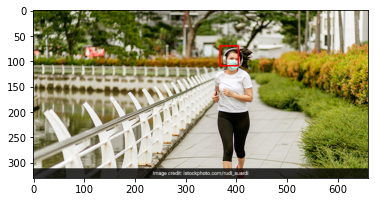

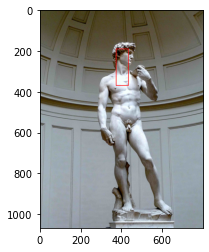

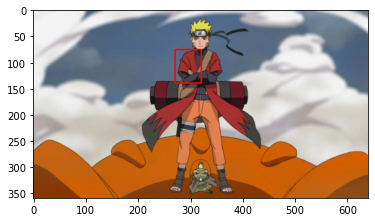

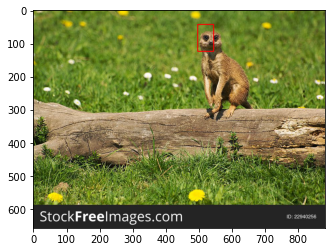

In [ ]:
predictions_cnn = model_cnn_100.predict(test_images, print_results=True)

### Comparison between models

Ya existe el subdirectorio o el archivo results.


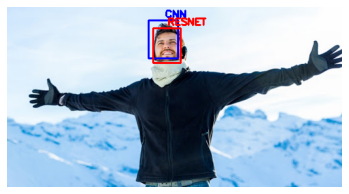

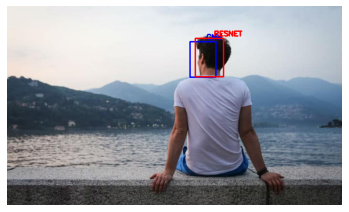

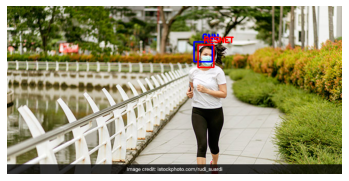

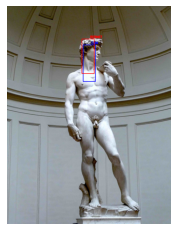

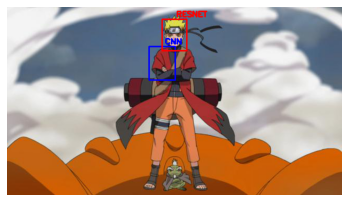

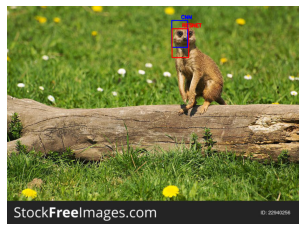

In [ ]:
# Comparing predictions
!mkdir results
thickness = 2
for i in range(len(test_images)):
    img = cv2.imread(test_images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cnn_s_x,cnn_s_y,cnn_f_x, cnn_f_y = [ int(p) for p in predictions_cnn[i,:]] # Coordinates of the rectangle start and finish point
    res_s_x,res_s_y,res_f_x, res_f_y = [ int(p) for p in predictions_resnet[i,:]] # Coordinates of the rectangle start and finish point

    #CNN
    color = (0, 0, 255)
    img = cv2.rectangle(img, (cnn_s_x, cnn_s_y), (cnn_f_x, cnn_f_y) ,color , thickness)
    cv2.putText(img,"CNN",(cnn_f_x-20,cnn_s_y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
        
    #RESNET
    color = (255, 0, 0)
    img = cv2.rectangle(img, (res_s_x, res_s_y), (res_f_x, res_f_y) ,color , thickness)
    cv2.putText(img,"RESNET",(res_f_x-20,res_s_y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)
    
    
    cv2.imwrite(rf"results/{test_images[i].split('/')[-1]}",cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
    

In [ ]:
del model_cnn_100, model_resnet_100
K.clear_session()

### Comparison by epochs

In the following cells it will be shown how the models have evolved during epochs.

In [ ]:
epochs = [10, 40, 60, 100]

#### CNN

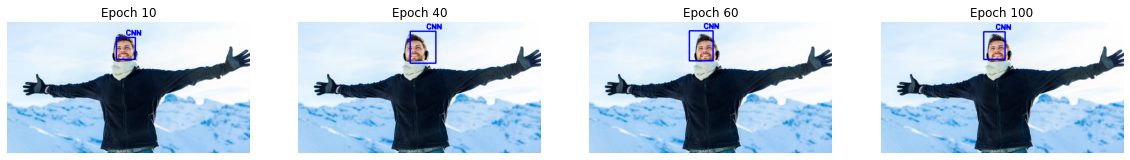

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')

thickness = 2
for i in range(len(epochs)):
    K.clear_session()
    gc.collect()
    
    plt.subplot(1,4,i+1)
    plt.axis('off')
    
    model = DeepPoseHeadDetection()
    model.load_weights(f"model_local_head/weights_{epochs[i]}.h5")
    
    cnn_s_x,cnn_s_y,cnn_f_x, cnn_f_y = [int(p) for p in model.predict(['testing/test.jpg'])[0]]
    
    #CNN
    color = (0, 0, 255)
    img = cv2.imread('testing/test.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (cnn_s_x, cnn_s_y), (cnn_f_x, cnn_f_y) ,color , thickness)
    cv2.putText(img,"CNN",(cnn_f_x-20,cnn_s_y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)   
    
    plt.imshow(img)
    plt.title(f'Epoch {epochs[i]}')
    
    
    
    del model

plt.savefig('cnn_during_epochs.jpg', dpi=300, bbox_inches='tight')

#### Resnet

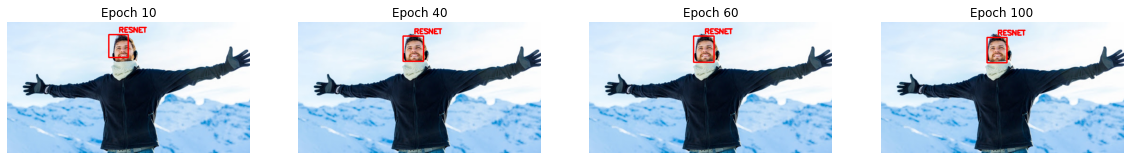

In [ ]:
K.clear_session()
gc.collect()


plt.figure(figsize=(20,10))
plt.axis('off')
for i in range(len(epochs)):
    plt.subplot(1,4,i+1)
    plt.axis('off')
    
    model = DeepPoseHeadDetection()
    model.load_model(f"model_local_resnet/model_{epochs[i]}.h5")
    
    res_s_x,res_s_y,res_f_x, res_f_y = [int(p) for p in model.predict(['testing/test.jpg'])[0]]
    
    #CNN
    color = (255, 0, 0)
    img = cv2.imread('testing/test.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (res_s_x, res_s_y), (res_f_x, res_f_y) ,color , thickness)
    cv2.putText(img,"RESNET",(res_f_x-20,res_s_y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)   
    
    plt.imshow(img)
    plt.title(f'Epoch {epochs[i]}')
    
    
    
    del model

plt.savefig('resnet_during_epochs.jpg', dpi=300, bbox_inches='tight')

### Activations

Filters learned by the Deep pose based model  in the first convolutional layer and the representation of the LRN layer and Max-pooling layer. 

In [ ]:
K.clear_session()
gc.collect()

11977

In [ ]:
model = DeepPoseHeadDetection()
model.load_weights(f"model_local_head/weights_100.h5")

E:\Users\danie\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


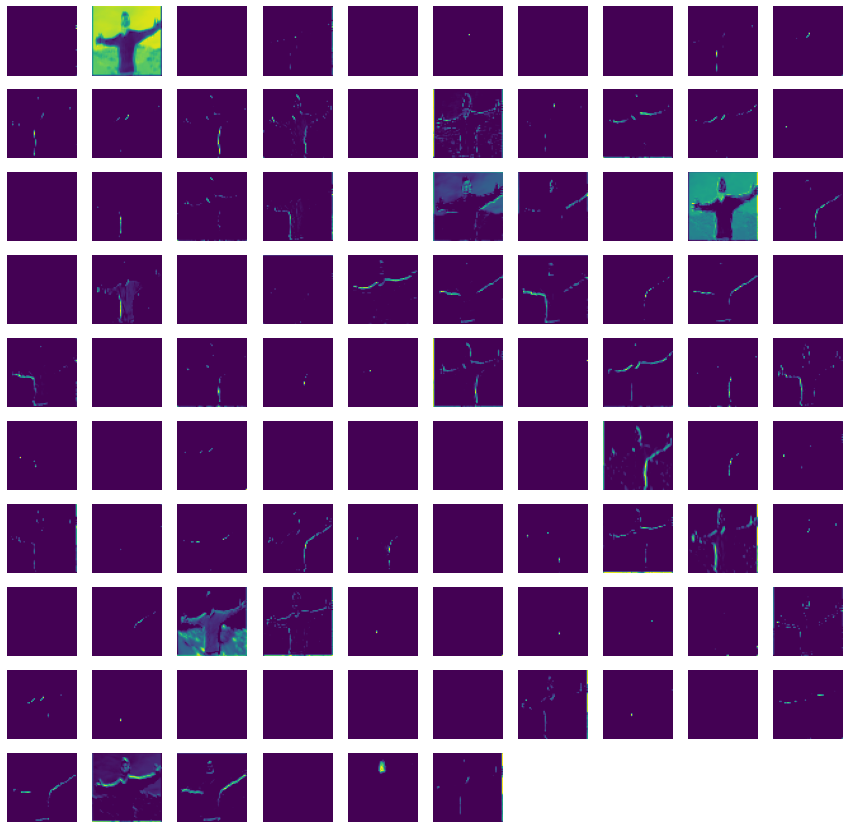

In [ ]:
# First Convolutional layer
print_activation(model.model,'testing/test.jpg',depth=2)

E:\Users\danie\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


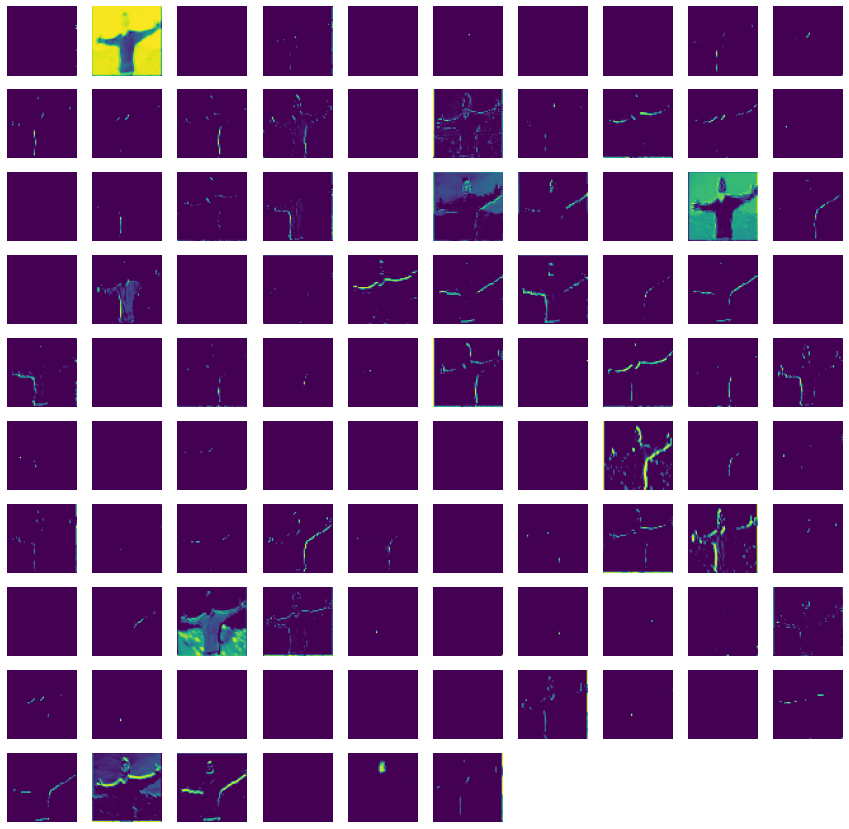

In [ ]:
# LRN Layer
print_activation(model.model,'testing/test.jpg',depth=3)

E:\Users\danie\anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


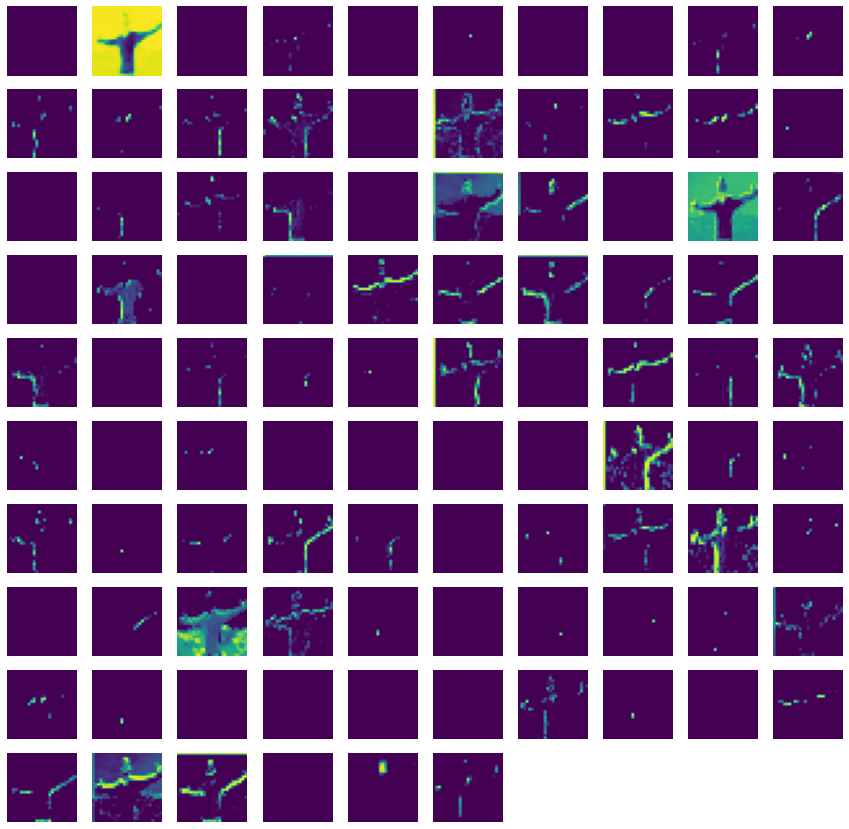

In [ ]:
#Max pooling layer
print_activation(model.model,'testing/test.jpg',depth=4)

## Pose estimation

In [ ]:
class DeepPoseJointDetection():
    '''
    Poner lo que usa la clase
    '''

    def __init__(self, model='deeppose'):

        if model == 'resnet':
            self.model = self._init_resnet()
        else:
            self.model = self._init_deeppose()

        self.model.compile(keras.optimizers.Adam(lr=0.0005), loss=["mean_squared_error"], metrics=[pck_h_50]) # Compile Model optimized by Adam and function loss as mean squared error

    def _init_deeppose(self):
        model = keras.models.Sequential()

        model.add(keras.layers.InputLayer(input_shape=(220,220,3))) # Input Layer
        model.add(tf.keras.layers.Lambda(lambda image: image/255)) # Normalization Layer for Computational time reduction
        model.add(keras.layers.Conv2D(96,11,activation='relu',strides=(4,4),input_shape=(220,220,3), padding='same')) # 11x11x96 Convolutional Layer (Relu activation function)
        model.add(keras.layers.Lambda(tf.nn.local_response_normalization)) # Local Response Normalization Layer
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
        model.add(keras.layers.Conv2D(256,5,activation='relu', padding='same')) # 5x5x256 Convolutional Layer (Relu activation function)
        model.add(keras.layers.Lambda(tf.nn.local_response_normalization)) # Local Response Normalization Layer
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
        model.add(keras.layers.Conv2D(384,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
        model.add(keras.layers.Conv2D(384,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
        model.add(keras.layers.Conv2D(256,3,activation='relu', padding = 'same')) # 3x3x384 Convolutional Layer (Relu activation function)
        model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) # 2x2 MaxPooling Layer
        model.add(keras.layers.Flatten()) # Vectorize
        model.add(keras.layers.Dense(4096,activation='relu')) # 4096 neurons - Full Connected Layer 
        model.add(keras.layers.Dropout(0.6))
        model.add(keras.layers.Dense(4096,activation='relu')) # 4096 neurons - Full Connected Layer
        model.add(keras.layers.Dropout(0.6))
        model.add(keras.layers.Dense(32,activation='relu')) # Output Layer
        return model

    def _init_resnet(self):
        model = tf.keras.applications.ResNet50V2(input_shape=(220,220,3),include_top=False)
        out = model.output
        out = keras.layers.Dense(2048,activation='relu')(out) # 4096 neurons - Full Connected Layer 
        out = keras.layers.Dense(2048,activation='relu')(out) # 4096 neurons - Full Connected Layer  
        out = keras.layers.Flatten()(out)
        out = keras.layers.Dense(32,activation='relu')(out) #Output Layer

        return keras.Model(model.input,out)

    def summary(self):
        print(self.model.summary())

    def load_model(self,model_path):
        self.model = keras.models.load_model(model_path)

    def fit(self,X ,Y ,epochs = 100, batch_size = 128, save_model = False, save_model_path= None, save_weights = False, save_weights_path= None):
        train_x_dataframe = pd.DataFrame(data = X, columns=['filename'])
        target_dataframe = pd.DataFrame(data = Y, columns=['y_col']*32)
        dt = pd.concat([train_x_dataframe,target_dataframe], axis=1)

        gn = keras.preprocessing.image.ImageDataGenerator(validation_split=0.1) # Image Data Generator for reducing RAM usage

        class CustomModelSaver(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
                    filename = f"model_{epoch}.h5"
                    self.model.save(join(save_model_path,filename))

        class CustomWeightsSaver(keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                if epoch % 10 == 0:  # or save after some epoch, each k-th epoch etc.
                    filename = f"weights_{epoch}.h5"
                    self.model.save_weights(join(save_weights_path,filename))
                    
        callbacks = []
        
        if save_model:
            callbacks.append(CustomModelSaver())
            
        if save_weights:
            callbacks.append(CustomWeightsSaver())

        train_set = gn.flow_from_dataframe(dt,target_size=(220, 220),y_col='y_col',class_mode='raw', batch_size=batch_size, subset="training")
        validation_set = gn.flow_from_dataframe(dt,target_size=(220, 220),y_col='y_col',class_mode='raw', batch_size=batch_size, subset="validation")

        return self.model.fit(train_set, validation_data= validation_set,epochs=epochs,verbose=1, callbacks=callbacks)

    def predict(self,X, print_results= False, save_fig=False):
        predictions  = np.array([])

        for image_path in tqdm(X):
            width, height = imagesize.get(image_path)

            # Predicting
            prediction = self.model.predict(resize(image_path).reshape([1,220,220,3])) #32 values (2*16)

            # Converting to real image dims
            for i in range(0,32,2):
                prediction[0,i] = int(prediction[0,i]/220 * width)
                prediction[0,i+1] = int(prediction[0,i+1]/220 * height)

            predictions = np.append(predictions, prediction)

            if print_results:
                image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
                prev_joint = None
                for i in range(0,32,2):
                    joint_x, joint_y = (prediction[0,i], prediction[0,i+1])


                    if((joint_x < 1 and joint_y < 1) or (joint_x > width or joint_y > height)):
                        continue
                    
                    line_color = (255, 0, 0)
                    line_thickness = 2
                    
                    # Printing the lines between joints

                    # 0-5 right leg to left leg
                    # 6 - 9 pelvis to head
                    # 10 - 15 right wrist to left wrist
                    if i == 0 or i== 12 or i== 20 or not prev_joint:
                      prev_joint = (joint_x,joint_y)
                    else:
                      image = cv2.line(image, (joint_x,joint_y),prev_joint, color=line_color, thickness=line_thickness)
                      prev_joint = (joint_x,joint_y)

                    point_color = (0, 255, 0)
                    point_thickness = -1
                    image = cv2.circle(image, (joint_x,joint_y), radius=5, color=point_color, thickness=point_thickness)

                plt.figure()
                plt.imshow(image)
                if save_fig:
                    plt.axis('off')
                    plt.savefig(f'results/{image_path.split("/")[-1].split(".")[0]}_pose.jpg', dpi=300, bbox_inches='tight')

        return predictions.reshape([-1,32])

    def save_model(self,path):
        self.model.save(path)

    def save_weights(self,path):
        self.model.save_weights(path)

    def load_weights(self,path):
        self.model.load_weights(path)

    def plot_model(self,path_w_filename):
        plot_model(self.model, to_file=path_w_filename, show_shapes=True, show_layer_names=True)

In [ ]:
model = DeepPoseJointDetection()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 220, 220, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
lambda_7 (Lambda)            (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
lambda_8 (Lambda)            (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 256)      

In [ ]:
%mkdir model_local_pose_pck
hist = model.fit(img_train_x_paths_reduced , img_train_y_pose.reshape([-1,32]) ,epochs = 300, batch_size = 128, save_weights = True, save_weights_path= "model_local_pose_pck")

Ya existe el subdirectorio o el archivo model_local_pose_pck.


Found 10353 validated image filenames.
Found 1150 validated image filenames.
Epoch 1/300
81/81 [==============================] - 207s 3s/step - loss: 9040.0684 - pck_h_50: 0.0607 - val_loss: 2295.2400 - val_pck_h_50: 0.1001
Epoch 2/300
81/81 [==============================] - 201s 2s/step - loss: 2414.6121 - pck_h_50: 0.0803 - val_loss: 2305.9905 - val_pck_h_50: 0.0980
Epoch 3/300
81/81 [==============================] - 204s 3s/step - loss: 2341.2139 - pck_h_50: 0.0836 - val_loss: 2315.0029 - val_pck_h_50: 0.0982
Epoch 4/300
81/81 [==============================] - 202s 2s/step - loss: 2288.7356 - pck_h_50: 0.0864 - val_loss: 2320.6179 - val_pck_h_50: 0.1066
Epoch 5/300
81/81 [==============================] - 202s 2s/step - loss: 2284.3479 - pck_h_50: 0.0880 - val_loss: 2230.0461 - val_pck_h_50: 0.1089
Epoch 6/300
81/81 [==============================] - 203s 3s/step - loss: 2259.6248 - pck_h_50: 0.0893 - val_loss: 2228.4143 - val_pck_h_50: 0.1136
Epoch 7/300
81/81 [================

81/81 [==============================] - 203s 3s/step - loss: 625.6040 - pck_h_50: 0.3296 - val_loss: 1947.8455 - val_pck_h_50: 0.2456
Epoch 56/300
81/81 [==============================] - 204s 3s/step - loss: 603.1702 - pck_h_50: 0.3323 - val_loss: 1956.1283 - val_pck_h_50: 0.2541
Epoch 57/300
81/81 [==============================] - 201s 2s/step - loss: 589.9309 - pck_h_50: 0.3382 - val_loss: 1996.8948 - val_pck_h_50: 0.2522
Epoch 58/300
81/81 [==============================] - 205s 3s/step - loss: 588.8724 - pck_h_50: 0.3376 - val_loss: 1991.0685 - val_pck_h_50: 0.2573
Epoch 59/300
81/81 [==============================] - 202s 2s/step - loss: 580.8409 - pck_h_50: 0.3425 - val_loss: 1973.2311 - val_pck_h_50: 0.2542
Epoch 60/300
81/81 [==============================] - 202s 2s/step - loss: 579.4997 - pck_h_50: 0.3417 - val_loss: 1944.0125 - val_pck_h_50: 0.2514
Epoch 61/300
81/81 [==============================] - 205s 3s/step - loss: 557.8024 - pck_h_50: 0.3484 - val_loss: 1929.6222 

81/81 [==============================] - 208s 3s/step - loss: 312.6634 - pck_h_50: 0.4768 - val_loss: 1874.3822 - val_pck_h_50: 0.2696
Epoch 111/300
81/81 [==============================] - 209s 3s/step - loss: 313.8375 - pck_h_50: 0.4786 - val_loss: 1968.4111 - val_pck_h_50: 0.2826
Epoch 112/300
81/81 [==============================] - 210s 3s/step - loss: 301.1511 - pck_h_50: 0.4848 - val_loss: 1924.1313 - val_pck_h_50: 0.2596
Epoch 113/300
81/81 [==============================] - 209s 3s/step - loss: 302.6695 - pck_h_50: 0.4823 - val_loss: 1914.0378 - val_pck_h_50: 0.2822
Epoch 114/300
81/81 [==============================] - 210s 3s/step - loss: 292.7901 - pck_h_50: 0.4901 - val_loss: 1929.3168 - val_pck_h_50: 0.2914
Epoch 115/300
81/81 [==============================] - 209s 3s/step - loss: 295.6575 - pck_h_50: 0.4895 - val_loss: 1916.7889 - val_pck_h_50: 0.2804
Epoch 116/300
81/81 [==============================] - 209s 3s/step - loss: 289.1511 - pck_h_50: 0.4969 - val_loss: 1908

81/81 [==============================] - 211s 3s/step - loss: 154.1709 - pck_h_50: 0.6249 - val_loss: 1868.0521 - val_pck_h_50: 0.3009
Epoch 166/300
81/81 [==============================] - 210s 3s/step - loss: 150.2551 - pck_h_50: 0.6297 - val_loss: 1878.1281 - val_pck_h_50: 0.3029
Epoch 167/300
81/81 [==============================] - 210s 3s/step - loss: 146.6873 - pck_h_50: 0.6334 - val_loss: 1840.3076 - val_pck_h_50: 0.3077
Epoch 168/300
81/81 [==============================] - 211s 3s/step - loss: 144.0066 - pck_h_50: 0.6418 - val_loss: 1844.7722 - val_pck_h_50: 0.3139
Epoch 169/300
81/81 [==============================] - 208s 3s/step - loss: 140.3370 - pck_h_50: 0.6455 - val_loss: 1853.4479 - val_pck_h_50: 0.3065
Epoch 170/300
81/81 [==============================] - 203s 3s/step - loss: 138.9874 - pck_h_50: 0.6434 - val_loss: 1875.7583 - val_pck_h_50: 0.3097
Epoch 171/300
81/81 [==============================] - 203s 3s/step - loss: 135.9454 - pck_h_50: 0.6518 - val_loss: 1874

81/81 [==============================] - 204s 3s/step - loss: 105.0049 - pck_h_50: 0.7039 - val_loss: 1885.9650 - val_pck_h_50: 0.3192
Epoch 221/300
81/81 [==============================] - 206s 3s/step - loss: 104.2730 - pck_h_50: 0.7067 - val_loss: 1911.0938 - val_pck_h_50: 0.3120
Epoch 222/300
81/81 [==============================] - 207s 3s/step - loss: 102.1612 - pck_h_50: 0.7095 - val_loss: 1881.3326 - val_pck_h_50: 0.3086
Epoch 223/300
81/81 [==============================] - 205s 3s/step - loss: 103.0427 - pck_h_50: 0.7051 - val_loss: 1865.5361 - val_pck_h_50: 0.3152
Epoch 224/300
81/81 [==============================] - 205s 3s/step - loss: 101.9111 - pck_h_50: 0.7103 - val_loss: 1881.9053 - val_pck_h_50: 0.3094
Epoch 225/300
81/81 [==============================] - 206s 3s/step - loss: 101.2588 - pck_h_50: 0.7125 - val_loss: 1857.6320 - val_pck_h_50: 0.3020
Epoch 226/300
81/81 [==============================] - 205s 3s/step - loss: 102.7218 - pck_h_50: 0.7067 - val_loss: 1889

81/81 [==============================] - 201s 2s/step - loss: 87.5256 - pck_h_50: 0.7408 - val_loss: 1930.2683 - val_pck_h_50: 0.3143
Epoch 276/300
81/81 [==============================] - 200s 2s/step - loss: 87.9535 - pck_h_50: 0.7362 - val_loss: 1932.8110 - val_pck_h_50: 0.3155
Epoch 277/300
81/81 [==============================] - 200s 2s/step - loss: 87.5745 - pck_h_50: 0.7400 - val_loss: 1928.2996 - val_pck_h_50: 0.3163
Epoch 278/300
81/81 [==============================] - 200s 2s/step - loss: 87.0123 - pck_h_50: 0.7445 - val_loss: 1952.1500 - val_pck_h_50: 0.3116
Epoch 279/300
81/81 [==============================] - 201s 2s/step - loss: 87.7558 - pck_h_50: 0.7379 - val_loss: 1920.9341 - val_pck_h_50: 0.3175
Epoch 280/300
81/81 [==============================] - 200s 2s/step - loss: 86.7862 - pck_h_50: 0.7426 - val_loss: 1919.4067 - val_pck_h_50: 0.3118
Epoch 281/300
81/81 [==============================] - 203s 3s/step - loss: 86.1284 - pck_h_50: 0.7439 - val_loss: 1928.3085 -

Two charts representing the performance of the Deep pose based model during the training process.

In the first chart is shown how the loss (MSE) of the model has changed during epochs for the training (blue line) and for the test set (orange).

In the second chart is shown how the PCKh metric has changed during epochs.

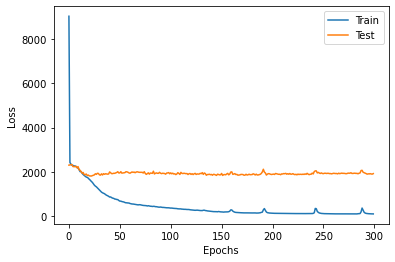

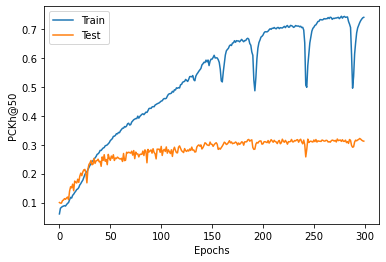

In [ ]:
# Loss during epochs
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Test'], loc='upper right')
plt.savefig('cnn_pose_epochs_mse.jpg', dpi=300, bbox_inches='tight')
plt.show()

# PCKh during epochs
plt.figure()
plt.plot(hist.history['pck_h_50'])
plt.plot(hist.history['val_pck_h_50'])
plt.ylabel('PCKh@50')
plt.xlabel('Epochs')
plt.legend(['Train','Test'], loc='upper left')
plt.savefig('cnn_pose_epochs_pckh.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.save_weights('model_local_pose_pck/weights_300.h5')

In [ ]:
model = DeepPoseJointDetection(model="resnet")
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 112, 112, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
%mkdir model_local_resnet_pose_pck
model.fit(img_train_x_paths_reduced,img_train_y_pose.reshape([-1,32]), save=True, save_path='model_local_resnet_pose_pck', batch_size=32, epochs=300)

Ya existe el subdirectorio o el archivo model_local_resnet_pose_pck.


Found 10353 validated image filenames.
Found 1150 validated image filenames.
Epoch 1/1000
324/324 [==============================] - 321s 991ms/step - loss: 1498.8055 - pck_h_50: 0.2355 - val_loss: 1444.4836 - val_pck_h_50: 0.3006
Epoch 2/1000
324/324 [==============================] - 207s 639ms/step - loss: 991.0472 - pck_h_50: 0.3355 - val_loss: 1478.8011 - val_pck_h_50: 0.3010
Epoch 3/1000
324/324 [==============================] - 206s 636ms/step - loss: 822.8800 - pck_h_50: 0.3899 - val_loss: 1331.0511 - val_pck_h_50: 0.3416
Epoch 4/1000
324/324 [==============================] - 205s 632ms/step - loss: 705.4102 - pck_h_50: 0.4133 - val_loss: 1327.3494 - val_pck_h_50: 0.3496
Epoch 5/1000
324/324 [==============================] - 207s 638ms/step - loss: 595.7118 - pck_h_50: 0.4590 - val_loss: 1362.7034 - val_pck_h_50: 0.3779
Epoch 6/1000
324/324 [==============================] - 209s 645ms/step - loss: 553.0084 - pck_h_50: 0.4683 - val_loss: 1310.8126 - val_pck_h_50: 0.3532
Epoc

Epoch 54/1000
324/324 [==============================] - 205s 633ms/step - loss: 294.6227 - pck_h_50: 0.5975 - val_loss: 1481.1185 - val_pck_h_50: 0.4238
Epoch 55/1000
324/324 [==============================] - 205s 634ms/step - loss: 118.7612 - pck_h_50: 0.7531 - val_loss: 1277.2271 - val_pck_h_50: 0.4551
Epoch 56/1000
324/324 [==============================] - 205s 634ms/step - loss: 50.3985 - pck_h_50: 0.8760 - val_loss: 1232.7180 - val_pck_h_50: 0.4892
Epoch 57/1000
324/324 [==============================] - 206s 634ms/step - loss: 25.9136 - pck_h_50: 0.9418 - val_loss: 1198.9331 - val_pck_h_50: 0.4944
Epoch 58/1000
324/324 [==============================] - 205s 633ms/step - loss: 18.0565 - pck_h_50: 0.9662 - val_loss: 1183.9025 - val_pck_h_50: 0.5001
Epoch 59/1000
324/324 [==============================] - 205s 632ms/step - loss: 14.9612 - pck_h_50: 0.9756 - val_loss: 1179.9519 - val_pck_h_50: 0.4947
Epoch 60/1000
324/324 [==============================] - 205s 632ms/step - loss:

324/324 [==============================] - 204s 629ms/step - loss: 10.9335 - pck_h_50: 0.9854 - val_loss: 1231.0237 - val_pck_h_50: 0.5244
Epoch 161/1000
324/324 [==============================] - 205s 633ms/step - loss: 11.3619 - pck_h_50: 0.9840 - val_loss: 1211.2222 - val_pck_h_50: 0.5304
Epoch 162/1000
324/324 [==============================] - 206s 636ms/step - loss: 11.2033 - pck_h_50: 0.9840 - val_loss: 1203.9634 - val_pck_h_50: 0.5293
Epoch 163/1000
324/324 [==============================] - 205s 631ms/step - loss: 11.1919 - pck_h_50: 0.9845 - val_loss: 1208.0094 - val_pck_h_50: 0.5302
Epoch 164/1000
324/324 [==============================] - 204s 629ms/step - loss: 11.1049 - pck_h_50: 0.9846 - val_loss: 1201.5620 - val_pck_h_50: 0.5345
Epoch 165/1000
324/324 [==============================] - 204s 630ms/step - loss: 10.9336 - pck_h_50: 0.9857 - val_loss: 1195.5352 - val_pck_h_50: 0.5306
Epoch 166/1000
324/324 [==============================] - 204s 631ms/step - loss: 11.6499 -

324/324 [==============================] - 218s 672ms/step - loss: 8.3214 - pck_h_50: 0.9911 - val_loss: 1258.7931 - val_pck_h_50: 0.5317
Epoch 267/1000
324/324 [==============================] - 219s 677ms/step - loss: 6.3149 - pck_h_50: 0.9949 - val_loss: 1249.3058 - val_pck_h_50: 0.5253
Epoch 268/1000
324/324 [==============================] - 217s 670ms/step - loss: 6.1241 - pck_h_50: 0.9953 - val_loss: 1260.1655 - val_pck_h_50: 0.5327
Epoch 269/1000
324/324 [==============================] - 216s 665ms/step - loss: 5.6751 - pck_h_50: 0.9951 - val_loss: 1261.8206 - val_pck_h_50: 0.5308
Epoch 270/1000
324/324 [==============================] - 215s 663ms/step - loss: 6.1689 - pck_h_50: 0.9943 - val_loss: 1257.9664 - val_pck_h_50: 0.5360
Epoch 271/1000
324/324 [==============================] - 223s 689ms/step - loss: 6.8523 - pck_h_50: 0.9929 - val_loss: 1242.5096 - val_pck_h_50: 0.5344
Epoch 272/1000
324/324 [==============================] - 217s 668ms/step - loss: 7.1473 - pck_h_

KeyboardInterrupt: 

Two charts representing the performance of the ResNet model during the training process.

In the first chart is shown how the loss (MSE) of the model has changed during epochs for the training (blue line) and for the test set (orange).

In the second chart is shown how the PCKh metric has changed during epochs.

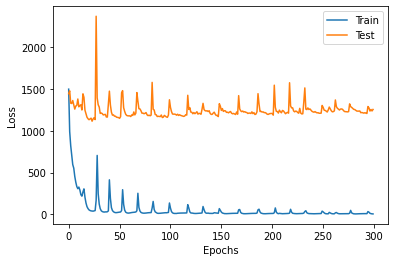

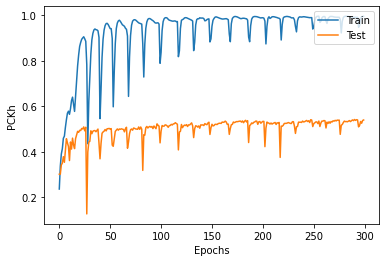

In [ ]:
train_loss = []
train_pckh = []
eval_loss = []
eval_pckh = []
y = 0
with open('pose_resnet_training.txt') as file:
  for line in file:
    train_loss.append(float(line.split(' ')[0]))
    train_pckh.append(float(line.split(' ')[1]))
    eval_loss.append(float(line.split(' ')[2]))
    eval_pckh.append(float(line.split(' ')[3]))
plt.figure()
plt.plot(train_loss)
plt.plot(eval_loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'],loc='upper right')
plt.savefig('resnet_pose_training_loss.jpg', format = 'jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

plt.plot(train_pckh)
plt.plot(eval_pckh)
plt.ylabel('PCKh')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'],loc='upper right')
plt.savefig('resnet_pose_training_PCKh.jpg', format = 'jpg', dpi = 300, bbox_inches = 'tight')
plt.show()

## Some testing and visualizations

Visual representations of how the predictions are fitted into the people in the images.

In [ ]:
test_images = ['testing/test_bengio.jpg','testing/test_elder.jpg','testing/test_yoga.jpg','testing/test_barman.jpg','testing/test_anime.jpeg','testing/test_venus.jpg']

#### CNN

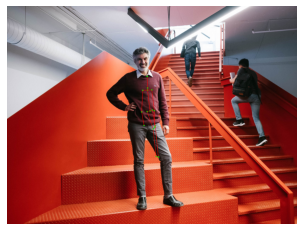

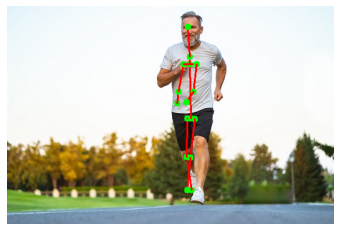

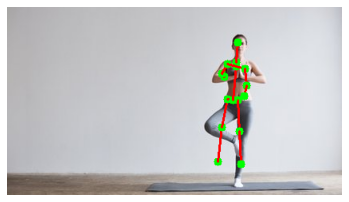

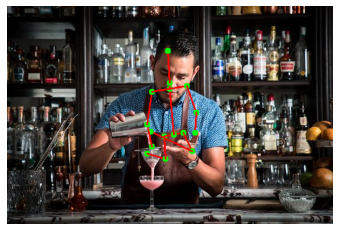

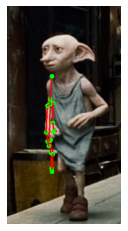

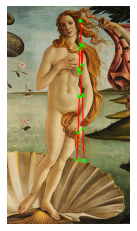

In [ ]:
cnn_model = DeepPoseJointDetection()
cnn_model.load_weights('model_local_pose_pck/weights_300.h5')
prediction_cnn = cnn_model.predict(test_images,print_results=True,save_fig=True)

In [ ]:
del cnn_model
K.clear_session()
gc.collect()

84778

#### ResNet

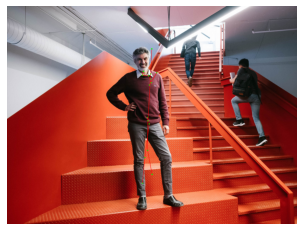

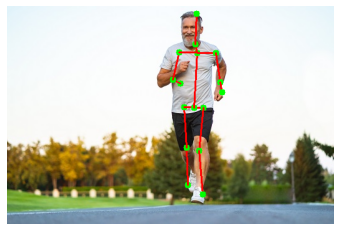

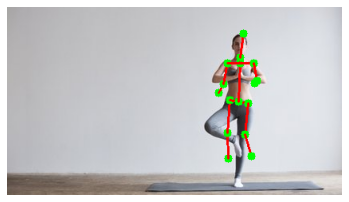

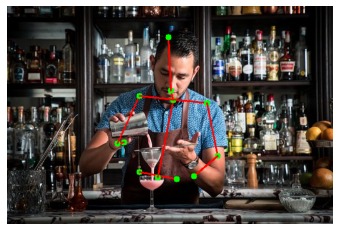

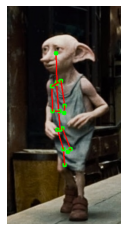

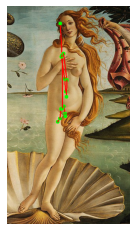

In [ ]:
resnet_model = DeepPoseJointDetection()
dependencies = {
    'pck_h_50': pck_h_50
}
resnet_model.model = keras.models.load_model('model_local_resnet_pose_pck/model_300.h5', custom_objects= dependencies)
prediction_resnet = resnet_model.predict(test_images,print_results=True, save_fig=True)

### Activations

Filters learned by the Deep pose based model  in the first convolutional layer and the representation of the LRN layer and Max-pooling layer. 

In [ ]:
K.clear_session()
gc.collect()

10893

In [ ]:
model = DeepPoseJointDetection()
model.load_weights(f"model_local_pose_pck/weights_300.h5")

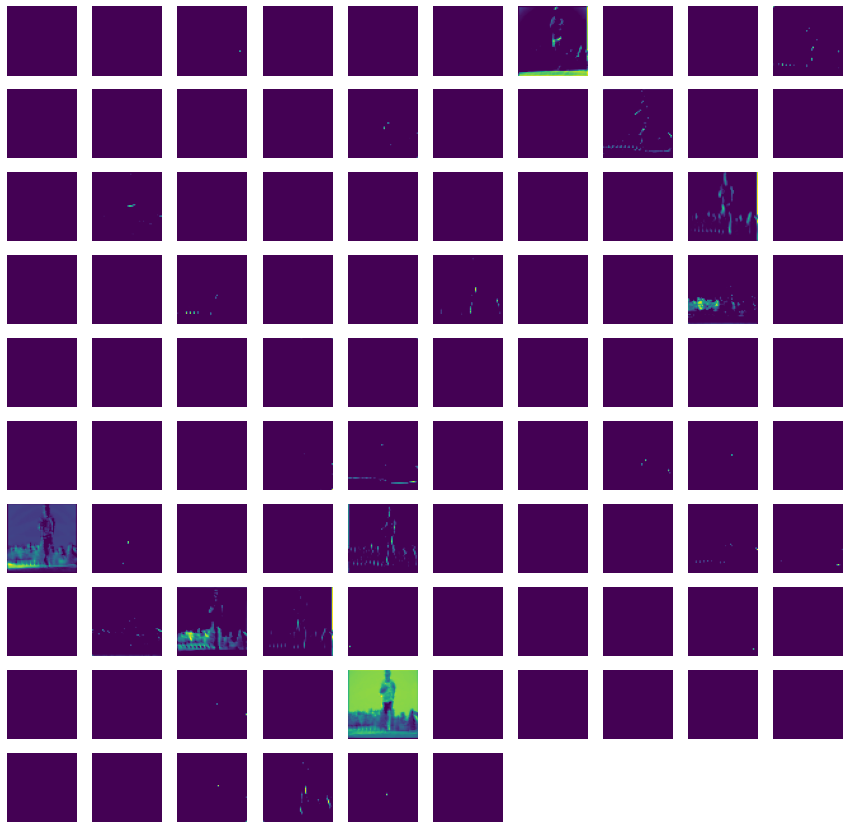

In [ ]:
print_activation(model.model, "testing/test_elder.jpg", depth=2,)

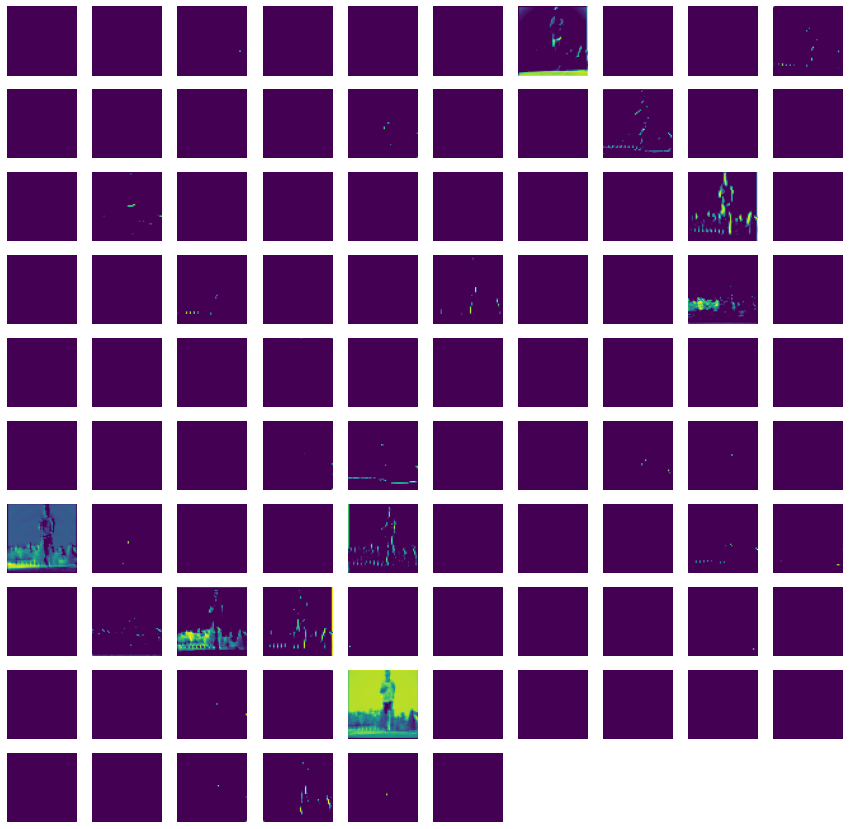

In [ ]:
print_activation(model.model, "testing/test_elder.jpg", depth=3)

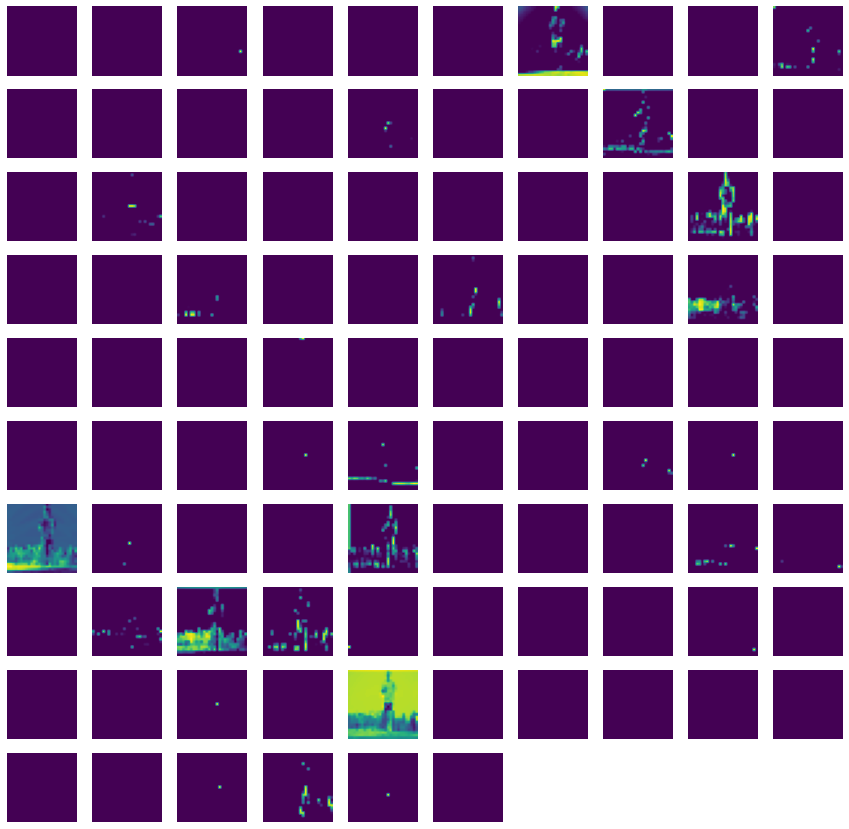

In [ ]:
print_activation(model.model, "testing/test_elder.jpg", depth=4)

## Comparison by epochs

In [ ]:
K.clear_session()
gc.collect()

111261

In [ ]:
epochs = [50, 100,  250,300]

### CNN

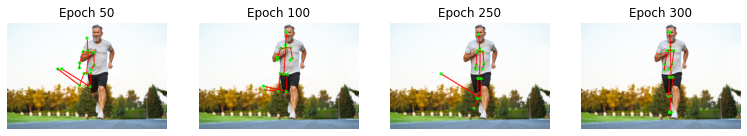

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')

thickness = 2
for e in range(len(epochs)):
  K.clear_session()
  gc.collect()
  
  plt.subplot(1,6,e+1)
  plt.axis('off')
  
  model = DeepPoseJointDetection()
  model.load_weights(f"model_local_pose_pck/weights_{epochs[e]}.h5")
  
  prediction = [int(p) for p in model.predict(['testing/test_elder.jpg'])[0]]

  width, height = imagesize.get('testing/test_elder.jpg')

  image = cv2.cvtColor(cv2.imread('testing/test_elder.jpg'), cv2.COLOR_BGR2RGB)
  prev_joint = None
  for i in range(0,32,2):
    joint_x, joint_y = (prediction[i], prediction[i+1])
    
    if((joint_x < 1 and joint_y < 1) or (joint_x > width or joint_y > height)):
        continue
    
    line_color = (255, 0, 0)
    line_thickness = 2

    # 0-5 right leg to left leg
    # 6 - 9 pelvis to head
    # 10 - 15 right wrist to left wrist
    if i == 0 or i== 12 or i== 20 or not prev_joint:
      prev_joint = (joint_x,joint_y)
    else:
      image = cv2.line(image, (joint_x,joint_y),prev_joint, color=line_color, thickness=line_thickness)
      prev_joint = (joint_x,joint_y)

    point_color = (0, 255, 0)
    point_thickness = -1
    image = cv2.circle(image, (joint_x,joint_y), radius=5, color=point_color, thickness=point_thickness)

  plt.imshow(image)
  plt.title(f'Epoch {epochs[e]}')

  del model
plt.savefig(f'cnn_pose_epochs.jpg', dpi=300, bbox_inches='tight')

### ResNet

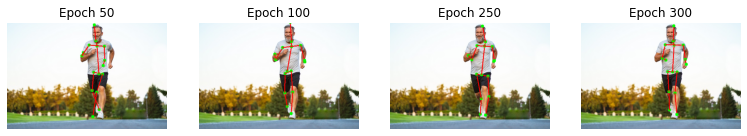

In [ ]:
plt.figure(figsize=(20,10))
plt.axis('off')

thickness = 2
for e in range(len(epochs)):
  K.clear_session()
  gc.collect()
  
  plt.subplot(1,6,e+1)
  plt.axis('off')
  
  model = DeepPoseJointDetection()
  dependencies = {
    'pck_h_50': pck_h_50
  }
  model.model = keras.models.load_model(f"model_local_resnet_pose_pck/model_{epochs[e]}.h5", custom_objects= dependencies)  
  prediction = [int(p) for p in model.predict(['testing/test_elder.jpg'])[0]]

  width, height = imagesize.get('testing/test_elder.jpg')

  image = cv2.cvtColor(cv2.imread('testing/test_elder.jpg'), cv2.COLOR_BGR2RGB)
  prev_joint = None
  for i in range(0,32,2):
    joint_x, joint_y = (prediction[i], prediction[i+1])
    
    if((joint_x < 1 and joint_y < 1) or (joint_x > width or joint_y > height)):
        continue
    
    line_color = (255, 0, 0)
    line_thickness = 2

    # 0-5 right leg to left leg
    # 6 - 9 pelvis to head
    # 10 - 15 right wrist to left wrist
    if i == 0 or i== 12 or i== 20 or not prev_joint:
      prev_joint = (joint_x,joint_y)
    else:
      image = cv2.line(image, (joint_x,joint_y),prev_joint, color=line_color, thickness=line_thickness)
      prev_joint = (joint_x,joint_y)

    point_color = (0, 255, 0)
    point_thickness = -1
    image = cv2.circle(image, (joint_x,joint_y), radius=5, color=point_color, thickness=point_thickness)

  plt.imshow(image)
  plt.title(f'Epoch {epochs[e]}')

  del model

plt.savefig(f'pose_resnet_epochs.jpg', dpi=300, bbox_inches='tight')

# Additional Content

### Generating videos for Head Detection

In this additional section it's show how the models can be applied to any video file and export it with the predictions drawn over the predicted sections.

Some examples of the models performance in videos:



*   [Yann Lecun talk](https://mega.nz/file/Nx8VBQaA#u4_o7OVL6Vtj2Eo9A34PEd3p5r-rcDz5qJVUY_JxiTg)
*   [Billie Elish music video](https://mega.nz/file/l50XBaTa#Dxd18j7RQ2D9ENm_BPpDFtdSg7qal3TvAzCw-u0dQmw)

*   [Anime video](https://mega.nz/file/Apl1wSgB#HHrikxJzSW7M2hZRa4jrsEzzowov3b9uHF1wKJaZYSE)
*   [Billi Elish cartoon](https://mega.nz/file/x19xkSqD#iWWNt7b2cqQTayv0mRcloqRdCvtOEwIeZzTOsjCZvqM)







In [ ]:
# Loading the two models
cnn = DeepPoseHeadDetection()
cnn.load_weights("model_local_head/weights_100.h5")
resnet = DeepPoseHeadDetection()
resnet.load_model("model_local_resnet/model_100.h5")

In [ ]:
# Paths of the input/output files
videos = ['videos/billie.mp4', 'videos/yann_lecun.mp4' ]
output_paths = ['videos/billie_predicted.avi', 'videos/yann_lecun_predicted.avi' ]

In [ ]:
def generate_head_detection_video(input_video,output_path, cnn, resnet):
  cap = cv2.VideoCapture(input_video)

  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

  frame_width = int(cap.get(3)) 
  frame_height = int(cap.get(4)) 

  size = (frame_width, frame_height) 

  result = cv2.VideoWriter(output_path,  
                          cv2.VideoWriter_fourcc(*'MJPG'), 
                          30, size)

  pbar = tqdm(total=length)
  while cap.isOpened():
      ret, frame = cap.read()
      
      if ret:
        input = cv2.resize(frame, (220,220))

        width = frame.shape[1]
        height = frame.shape[0]

        # Predicting
        prediction = resnet.model.predict(input.reshape([1,220,220,3]))
        
        x1, x2 = prediction[0,0]/220 * width, prediction[0,2]/220 * width
        y1, y2 = prediction[0,1]/220 * height, prediction[0,3]/220 * height
        prediction = [int(x1), int(y1), int(x2), int(y2)]
        
        start_point = (prediction[0], prediction[1])
        end_point = (prediction[2], prediction[3])
        color = (0, 255, 0)
        thickness = 2

        
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
        cv2.putText(frame,"ResNet",(end_point[0]-20,start_point[1]-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
        
        prediction = cnn.model.predict(input.reshape([1,220,220,3]))
        
        x1, x2 = prediction[0,0]/220 * width, prediction[0,2]/220 * width
        y1, y2 = prediction[0,1]/220 * height, prediction[0,3]/220 * height
        prediction = [int(x1), int(y1), int(x2), int(y2)]
        
        start_point = (prediction[0], prediction[1])
        end_point = (prediction[2], prediction[3])
        color = (0, 0, 255)
        thickness = 2
        
        frame = cv2.rectangle(frame, start_point, end_point, color, thickness)
        cv2.putText(frame,"CNN",(end_point[0]-20,start_point[1]-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),2)

        result.write(frame)
      else:
          break
      pbar.update(1)

  pbar.close()
  cap.release()
  result.release()

In [ ]:
for i in range(len(videos)):
  generate_head_detection_video(videos[i], output_paths[i], cnn, resnet)

In [ ]:
generate_head_detection_video('videos/anime.mp4','videos/anime_predicted.avi', cnn, resnet)

In [ ]:
generate_head_detection_video('videos/animated_billie.mp4','videos/billie2_predicted.avi', cnn, resnet)